## Assignement 2
### Food Hazard Detection

## 1. Data Loading and Inspection
First step is to load the data directly from github repository and take a look into an overview of the dataframe that we create

In [4]:
#from google.colab import drive
import pandas as pd

# Mount Google Drive
#drive.mount('/content/drive')

# Define the path to the file on Google Drive
file_path = r"C:\Users\steli\OneDrive\Desktop\Stelios\DSAUEB\Trimester 1\PDS\A2\PDS-A2\Data\incidents_train.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Initial inspection of the data
data_overview = {
    'Shape': df.shape,
    'Columns': df.columns.tolist(),
    'df Types': df.dtypes,
    'Missing Values': df.isnull().sum(),
}

print(data_overview)


{'Shape': (5082, 11), 'Columns': ['Unnamed: 0', 'year', 'month', 'day', 'country', 'title', 'text', 'hazard-category', 'product-category', 'hazard', 'product'], 'df Types': Unnamed: 0           int64
year                 int64
month                int64
day                  int64
country             object
title               object
text                object
hazard-category     object
product-category    object
hazard              object
product             object
dtype: object, 'Missing Values': Unnamed: 0          0
year                0
month               0
day                 0
country             0
title               0
text                0
hazard-category     0
product-category    0
hazard              0
product             0
dtype: int64}


### Dropping Unnecessary Index Column
Removing not meaningful columns such as index

In [5]:
# Drop the unnecessary index column
df = df.drop(columns=['Unnamed: 0'])
df

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast
...,...,...,...,...,...,...,...,...,...,...
5077,2022,7,28,hk,Imported biscuit may contain allergen (peanuts),Imported biscuit may contain allergen (peanuts...,allergens,cereals and bakery products,peanuts and products thereof,biscuits
5078,2022,7,28,us,Danny’s Sub and Pizza Recalls Meat Pizza Produ...,023-2022\n\n \n High - Class I\n\n Produc...,fraud,prepared dishes and snacks,inspection issues,pizza
5079,2022,7,29,us,Lyons Magnus Voluntarily Recalls 53 Nutritiona...,"FRESNO, Calif. – July 28, 2022 – Lyons Magnus ...",biological,non-alcoholic beverages,cronobacter spp,non-alcoholic beverages
5080,2022,7,30,us,"Conagra Brands, Inc., Recalls Frozen Beef Prod...",025-2022\n\n \n High - Class I\n\n Misbra...,allergens,"meat, egg and dairy products",eggs and products thereof,frozen beef products


### Statistical summary of the data

In [6]:
# Generate statistical summary for numerical columns
numerical_summary = df.describe()
numerical_summary


,year,month,day
count,5082.000000,5082.000000,5082.000000
mean,2016.461433,6.347501,15.606848
std,4.910835,3.414958,8.653473
min,1994.000000,1.000000,1.000000
25%,2015.000000,3.000000,8.000000
50%,2018.000000,6.000000,15.000000
75%,2020.000000,9.000000,23.000000
max,2022.000000,12.000000,31.000000


The dataset spans from 1994 to 2022, with most incidents occurring in recent years, particularly after 2015. The average incident year is 2016, indicating a focus on modern data, while monthly values center around June, hinting at potential mid-year peaks. Incident days average around the 15th, suggesting a balanced distribution across the month. Quartile analysis shows that most incidents (75%) occurred between 2015 and 2022, pointing to a recent and perhaps seasonal relevance in the data, which could be valuable for time-series and trend analysis.

In [7]:
# Generate a summary for categorical columns
categorical_summary = df.describe(include=['object'])
categorical_summary

,country,title,text,hazard-category,product-category,hazard,product
count,5082,5082,5082,5082,5082,5082,5082
unique,9,4948,5053,10,22,128,1022
top,us,Various raw beef and raw veal products recalle...,"MG Foods of Charlotte, NC is expanding its rec...",allergens,"meat, egg and dairy products",listeria monocytogenes,ice cream
freq,2195,11,2,1854,1434,665,185


The dataset provides a multi-dimensional view of food hazard incidents, primarily from the U.S. but covering nine countries overall. Analysis shows a high degree of uniqueness in incident titles and descriptions, reflecting varied hazard cases. Categories like allergens and Listeria monocytogenes are common, often associated with products such as meat, dairy, and eggs. The data also reveals that specific products, especially ice cream, appear frequently, which might indicate recurring risks in certain food types.

# Exploratory Data Analysis

### Analysis for Categorical Columns

### Map of top 5 product categories per country

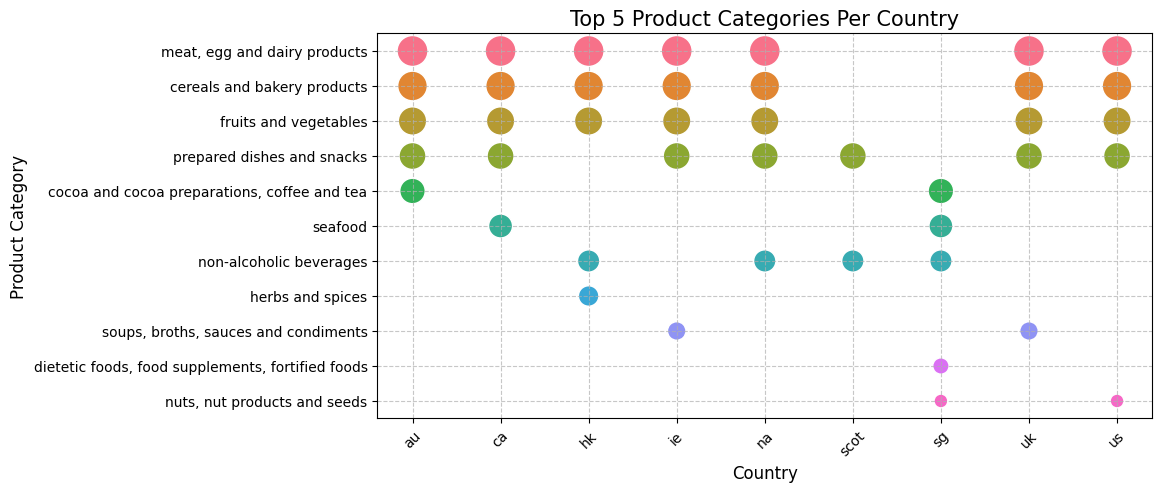

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Top 5 product categories per country
top_5_per_country = (
    df.groupby('country')['product-category']
    .value_counts()
    .groupby(level=0)
    .nlargest(5)
    .reset_index(level=0, drop=True)
    .reset_index()
)

# Plotting the map of top 5 product categories per country
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x='country', y='product-category', size='product-category',
    sizes=(100, 500), data=top_5_per_country, hue='product-category', legend=False
)
plt.title('Top 5 Product Categories Per Country', fontsize=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


This bubble chart shows the top 5 product categories per country, with larger bubbles indicating more frequent categories. Common categories like "meat, egg, and dairy products" and "cereals and bakery products" appear across most countries. Some countries, like the UK and Singapore, show more diverse product preferences, while others, like the US, have a few dominant categories. This highlights regional variations in food product consumption.

### Country Distribution


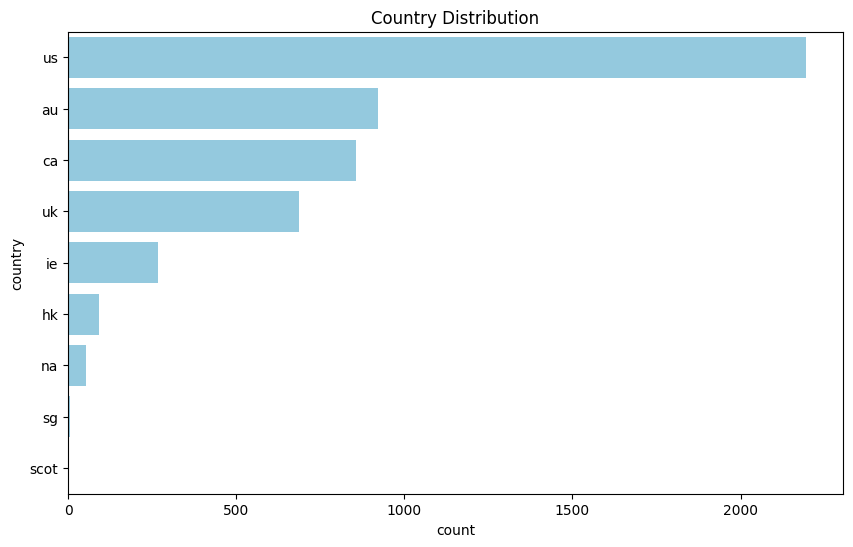

In [9]:
# Country Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    y='country', data=df,
    order=df['country'].value_counts().index,
    color="skyblue", legend=False
)
plt.title('Country Distribution')
plt.show()

The chart shows the distribution of data across countries, with the United States ("us") having the highest count, followed by Australia ("au") and Canada ("ca"). Countries like the UK, Ireland ("ie"), and Hong Kong ("hk") also have notable counts, but much lower compared to the US. The other countries such as Singapore ("sg"), Scotland ("scot"), and North America ("na") have smaller counts. This distribution suggests that the dataset is heavily skewed toward the US, which may lead to biases if used for analysis or predictive modeling.

### Hazard Category Distribution


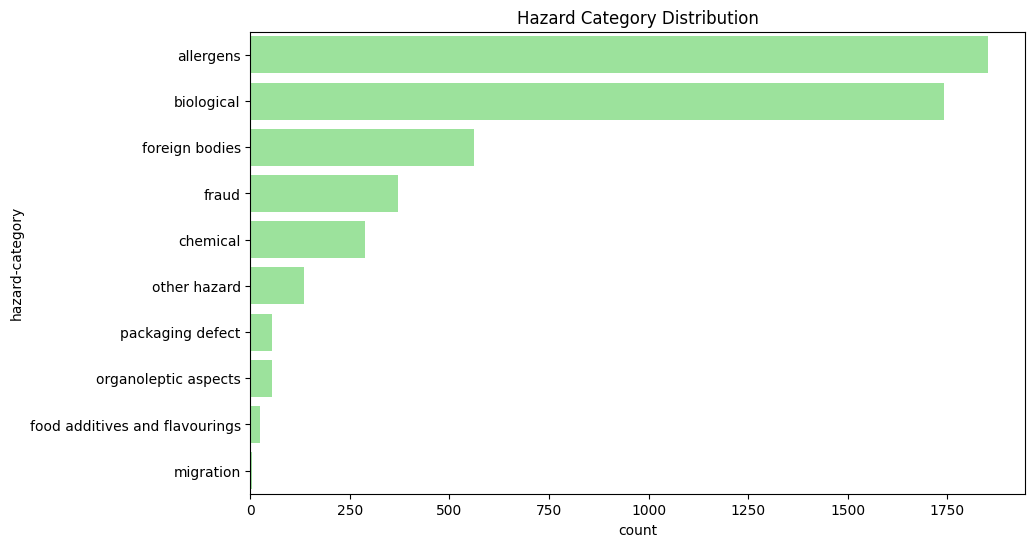

In [10]:
# Hazard Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    y='hazard-category', data=df,
    order=df['hazard-category'].value_counts().index,
    color="lightgreen", legend=False
)
plt.title('Hazard Category Distribution')
plt.show()

The chart shows the distribution of different hazard categories. "Allergens" and "biological" hazards have the highest counts, which dominate the dataset, while categories like "migration" and "food additives and flavourings" have much lower frequencies. This suggests that allergen and biological risks are the most prominent concerns in the data, which is useful for food safety analysis. However, the imbalance in hazard categories, with some hazards being more frequent than others, could lead to biased models or analyses that favor the more common hazards.

### Product Category Distribution


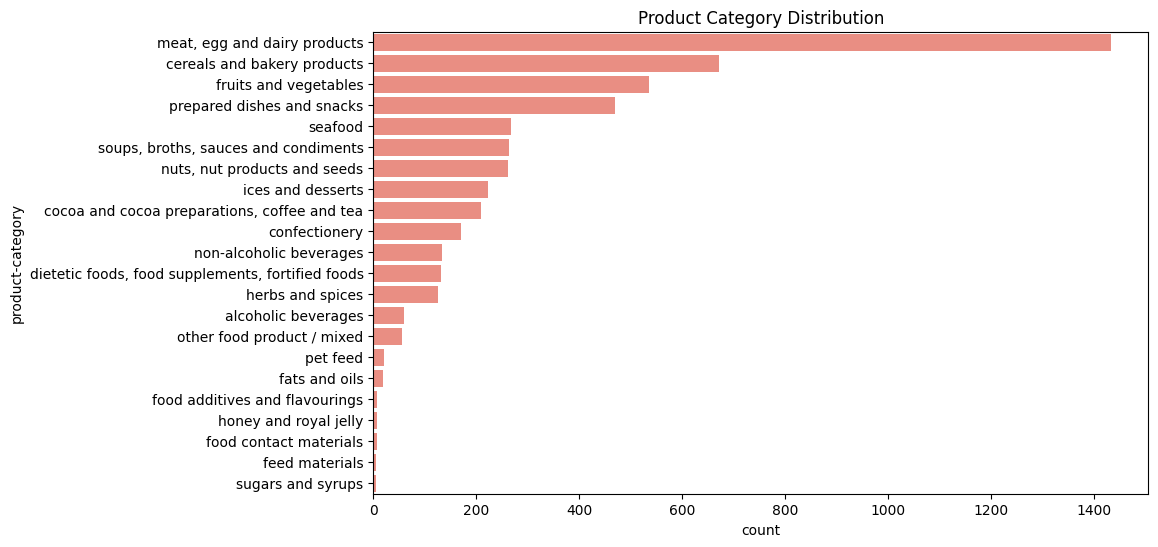

In [11]:
# Product Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(
    y='product-category', data=df,
    order=df['product-category'].value_counts().index,
    color="salmon", legend=False
)
plt.title('Product Category Distribution')
plt.show()

This bar chart visualizes the distribution of product categories, with the "meat, egg and dairy products" category showing the highest frequency, followed by "cereals and bakery products" and "fruits and vegetables." Categories such as "pet feed," "honey and royal jelly," and "sugars and syrups" are represented with significantly lower counts, indicating an imbalance in the dataset.

This imbalance suggests that certain product categories are overrepresented, which could lead to biased analyses or models that favor these dominant categories.

### Top 20 Hazards


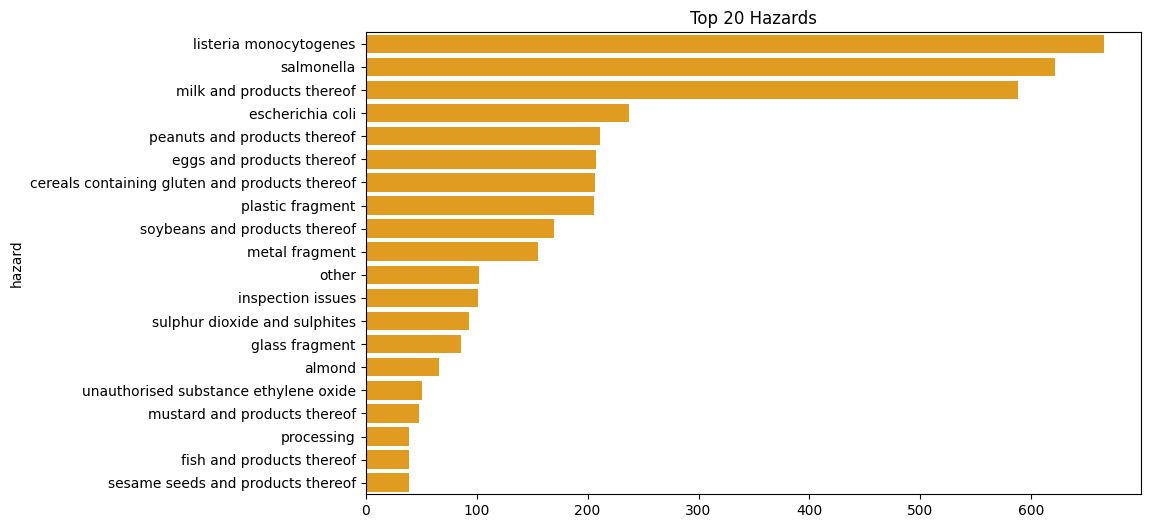

In [12]:
# Top 20 Hazards
top_20_hazards = df['hazard'].value_counts().nlargest(20)
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_20_hazards.index, x=top_20_hazards.values,
    color="orange", legend=False
)
plt.title('Top 20 Hazards')
plt.show()

The chart displays the distribution of the top 20 hazards in the dataset, with "Listeria monocytogenes" and "Salmonella" being the most prevalent, followed by "milk and products thereof," "Escherichia coli," and "peanuts and products thereof."

The chart highlights a potential focus area for food safety management in addressing microbial contamination and physical hazards in products, with overrepresentation of certain hazards that could influence the analysis or model outcomes.

### Top 20 Products


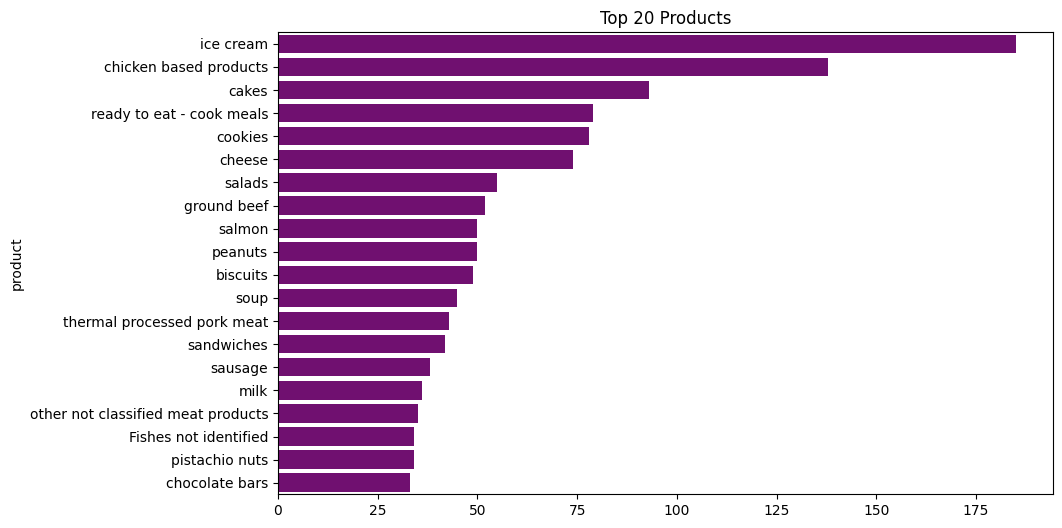

In [13]:
# Top 20 Products
top_20_products = df['product'].value_counts().nlargest(20)
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top_20_products.index, x=top_20_products.values,
    color="purple", legend=False
)
plt.title('Top 20 Products')
plt.show()

This bar chart shows the top 20 products in the dataset, with "ice cream" being the most frequently occurring product, followed by "chicken-based products" and "cakes." Other products like "cookies," "cheese," and "salads" also have significant counts. The chart suggests that certain food items are overrepresented, potentially influencing any analysis or model developed from this data.

### Year Distribution


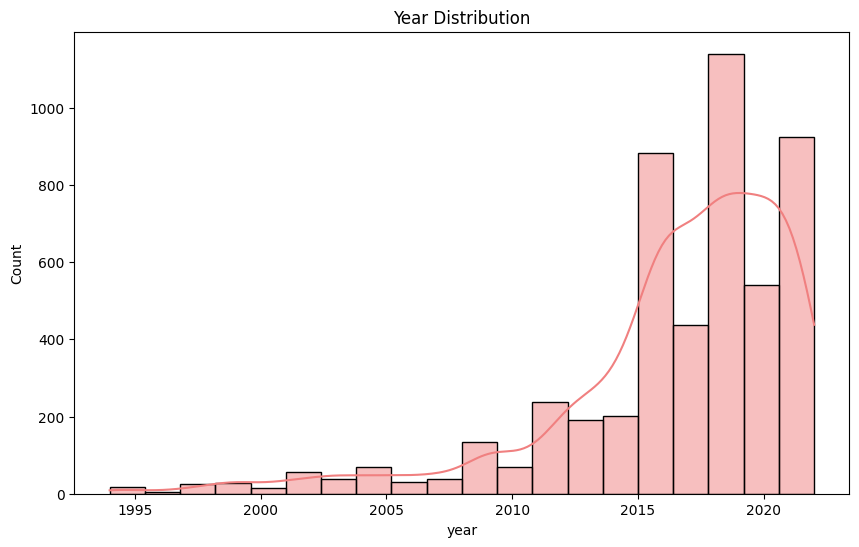

In [14]:
# Year Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['year'], bins=20, kde=True, color="lightcoral")
plt.title('Year Distribution')
plt.show()


The chart shows the distribution of data over the years. It indicates a sharp increase in the count of entries starting around 2010, with the highest peaks occurring in the years 2019 and 2020. This trend suggests a growing number of incidents, products, or reports over time, particularly in the more recent years. The relatively low counts before 2010 imply that data collection or reporting might have started later or that there were fewer occurrences in earlier years.

### Word Cloud and Top Words

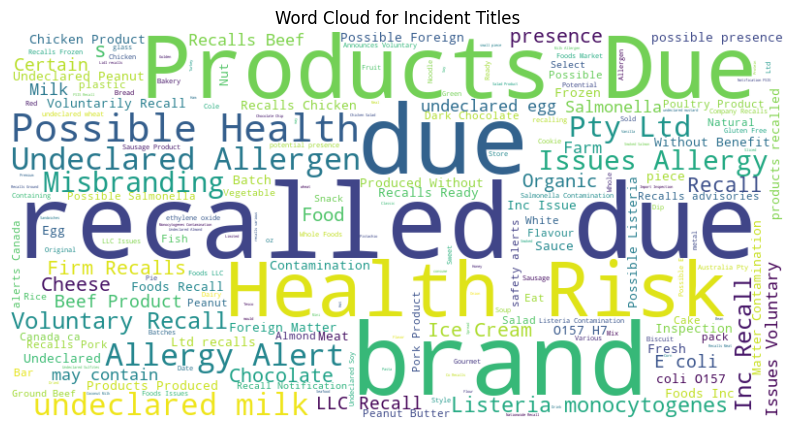

In [15]:
#!pip install wordcloud
from wordcloud import WordCloud

# Combine all titles into a single string
title_text = ' '.join(df['title'].dropna())

# Generate a word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Incident Titles")
plt.show()


The word cloud shows the most frequent terms associated with product recalls and incidents. Prominent words like "recalled," "due," "health," and "risk" highlight the primary focus on safety concerns, particularly related to potential health risks such as "allergen," "salmonella," and "Listeria monocytogenes." "Brand" and "products" are also frequently mentioned, suggesting that brand names and specific product recalls are central to the incidents

# Benchmarks - Advanced Model: PubMedBERT

In this task, we aim to classify food safety-related incidents based on two distinct types of input data: short texts (title) and long texts (text).

Using Advanced Model: PubMedBERT  


For each of these input types, we perform the following two subtasks:

**Subtasks (Performed Separately for  title and text):**

**Subtask 1:**

- Classify hazard-category (general hazard type).

- Classify product-category (general product type).

**Subtask 2:**

- Classify hazard (specific hazard).
- Classify product (specific product).

We use all features (year, month, day, country, and the text feature) as input.

Thus, we treat title and text as two distinct data sources, with each undergoing its own preprocessing, model training, and evaluation for all four targets.

## 1. Preprocessing and Splitting

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from sklearn.metrics import f1_score
# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
targets_subtask1 = ['hazard-category', 'product-category']
targets_subtask2 = ['hazard', 'product']



## 2. Build Pipelines and Train Models (PubMedBERT)

## PubMedBERT Classification Titles (Short Text):

In [17]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import pandas as pd

# Initialize dictionaries to store F1 scores and classification reports for both tasks
f1_scores = {'title': {}, 'text': {}}
classification_reports = {'title': {}, 'text': {}}

# Custom Dataset for PyTorch
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        label = torch.tensor(self.labels[item], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

# Function to prepare data for both title and text
def prepare_data(text_column):
    X = df[features + [text_column]]
    data_splits = {}
    for target in targets_subtask1 + targets_subtask2:
        X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

        # Fit the label encoder on the entire target column (train + test)
        le = LabelEncoder()
        y_train = le.fit_transform(df[target])  # Fit on the entire column
        y_test = le.transform(y_test)  # Transform both training and test

        data_splits[target] = (X_train, X_test, y_train, y_test)

    return data_splits

# Function to train and evaluate model for each subtask
def train_and_evaluate(text_column, task_type):
    tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
    data_splits = prepare_data(text_column)

    for target in targets_subtask1 + targets_subtask2:
        X_train, X_test, y_train, y_test = data_splits[target]

        num_labels = len(set(df[target]))

        model = BertForSequenceClassification.from_pretrained(
            "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels
        )

        # Create datasets for training and testing
        train_dataset = CustomDataset(X_train[text_column].values, y_train, tokenizer)
        test_dataset = CustomDataset(X_test[text_column].values, y_test, tokenizer)

        # Define Trainer arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=12,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
        )

        # Initialize Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=lambda p: {'f1': f1_score(p.predictions.argmax(axis=1), p.label_ids, average='weighted')}
        )

        # Train and evaluate the model
        trainer.train()

        # Get predictions and classification report
        predictions, label_ids, _ = trainer.predict(test_dataset)
        predicted_labels = predictions.argmax(axis=1)

        # Get F1 score
        f1 = f1_score(y_test, predicted_labels, average='weighted')
        f1_scores[task_type][target] = f1

        # Get the classification report
        report = classification_report(y_test, predicted_labels, target_names=list(set(df[target])))
        classification_reports[task_type][target] = report






## PubMedBERT Classification Titles (Short Text):

In [ ]:
import os
os.environ['WANDB_MODE'] = 'dryrun'

# Run Title-Based Classification
train_and_evaluate('title', 'title')

# Convert F1 scores to DataFrame
f1_df_title = pd.DataFrame(list(f1_scores['title'].items()), columns=['Subtask', 'F1 Score'])

# Print F1 Scores
print("F1 Scores for Title-Based Classification:")
print(f1_df_title)

# Print Classification Reports for Title and Text-Based
for target, report in classification_reports['title'].items():
    print(f"\nClassification Report for {target} (Title-based):")
    print(report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3060 [00:00<?, ?it/s]

## PubMedBERT Classification Texts (Long Text):

In [ ]:
import os
os.environ['WANDB_MODE'] = 'dryrun'

# Run Text-Based Classification
train_and_evaluate('text', 'text')

# Convert F1 scores to DataFrame
f1_df_text = pd.DataFrame(list(f1_scores['text'].items()), columns=['Subtask', 'F1 Score'])

# Print F1 Scores
print("\nF1 Scores for Text-Based Classification:")
print(f1_df_text)

# Print Classification Reports for Title and Text-Based
for target, report in classification_reports['text'].items():
    print(f"\nClassification Report for {target} (Text-based):")
    print(report)